# Analysis cell wall defomration
- it is an example for the submitted paper to construction and building materials

In [1]:
from common.cell_wall_deformation_analysis_func import *

In [2]:
# target_dir = './Data/HR-1/'
# filenames = natsort.natsorted([filename for filename in os.listdir(target_dir) if not filename.startswith('.')])
# im_list=[load_im(target_dir, file_name) for file_name in tqdm(filenames)][:193]

In [3]:
# np.save('./Data/image_sequence.npy', im_list)

In [4]:
im_list = np.load('./data/image_sequence.npy')

### Perform the watershed segmentation to analyze the cell wall defomration

In [5]:
nuclei_list=[] #segemented images
centroids_x_list=[] # x axis of centroids
centroids_y_list=[] # y axis of centroids
frame_num_list=[] # number of frame
labels_list=[] # number of labels

for i in tqdm(range(len(im_list))):
    #watershed segmentation
    nuclei, _=watershed_segmentation(im_list[i])
    
    #centroids extraction
    centroids_y, centroids_x, labels=extract_centroids(nuclei)
    
    #frame number
    frame_num=np.ones(len(centroids_y), dtype="int32")*i
    
    #save results
    nuclei_list.append(nuclei)
    centroids_y_list.extend(centroids_y)
    centroids_x_list.extend(centroids_x)
    frame_num_list.extend(frame_num)
    labels_list.extend(labels)

nuclei_list=np.asarray(nuclei_list)
centroids_y_list=np.asarray(centroids_y_list)
centroids_x_list=np.asarray(centroids_x_list)
frame_num_list=np.asarray(frame_num_list)
labels_list=np.asarray(labels_list)

#delete im_list and release memory
del im_list
gc.collect()

100%|███████████████████████████████████████████| 193/193 [05:36<00:00,  1.74s/it]


0

### Make Pandas dataframe for individual cell tracking

In [6]:
features_data=np.vstack((centroids_y_list, centroids_x_list, frame_num_list, labels_list)).T
features_frame=pd.DataFrame(features_data, columns=["y", "x", "frame", "label"])
features_frame.head()

,y,x,frame,label
0,1.888889,207.666672,0.0,1.0
1,9.518518,243.291000,0.0,2.0
2,1.000000,1058.500000,0.0,3.0
3,3.000000,363.000000,0.0,4.0
4,4.500000,1525.954590,0.0,5.0


### Perform the Crocker-Grier linking algorithm with trackpy

In [7]:
%%time
search_range= 3
track_result = tp.link_df(features_frame, search_range, memory=0)

Frame 192: 13413 trajectories present.
CPU times: user 31.3 s, sys: 779 ms, total: 32.1 s
Wall time: 32 s


In [8]:
#set check number
check_number=len(np.unique(track_result["frame"]))

#count the frequency of each particle in all frames
particle_num_list, counts=np.unique(track_result["particle"], return_counts=True)
    
#filtering dataframe based on above-extracted particle num
track_result_filtered=track_result[track_result.particle.isin(np.where(counts==check_number)[0])]

#extract particle num satisfying check number
nuclei_true = extract_cell_tracking_result(nuclei_list, track_result_filtered, check_number)

100%|███████████████████████████████████████████| 193/193 [01:17<00:00,  2.50it/s]


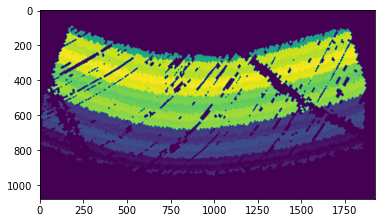

In [9]:
plt.imshow(nuclei_true[:,:,-1])

In [10]:
# np.save('./data/tracked_cell.npy', nuclei_true[:,:,4:])

### Measure the parameters for each tracked cell

In [11]:
area_lists = [] # measure cell area
ecc_lists = [] # measure cell eccentricity
aspect_axis_lists = [] # measure fitted ellipse aspect ratio
aspect_bbox_lists = [] # measure bounding box aspect ratio

for i in tqdm(range(check_number)):
    label = np.asarray([label for label in np.unique(nuclei_true[:,:,i])])
    props = regionprops(np.int32(nuclei_true[:,:,i]))
    
    #calculate each param
    area = np.asarray([props[j].area for j in range(len(props))])
    ecc = np.asarray([props[j].eccentricity for j in range(len(props))])
    major_axis = np.asarray([props[j].major_axis_length for j in range(len(props))])
    minor_axis = np.asarray([props[j].minor_axis_length for j in range(len(props))])
    aspect_ratio_axis = major_axis/minor_axis # calculate fitted ellipse aspect ratio
    vert = np.asarray([props[j].bbox[2] for j in range(len(props))])-np.asarray([props[j].bbox[0] for j in range(len(props))])
    hori = np.asarray([props[j].bbox[3] for j in range(len(props))])-np.asarray([props[j].bbox[1] for j in range(len(props))])
    aspect_ratio_bbox = vert/hori # calcuate bounding box aspect ratio
    
    # transform to lists
    area_list = np.stack((label[1:], area), axis=-1)
    ecc_list = np.stack((label[1:], ecc), axis=-1)
    aspect_axis_list = np.stack((label[1:], aspect_ratio_axis), axis=-1)
    aspect_bbox_list = np.stack((label[1:], aspect_ratio_bbox), axis=-1)

    area_lists.append(area_list)
    ecc_lists.append(ecc_list)
    aspect_axis_lists.append(aspect_axis_list)
    aspect_bbox_lists.append(aspect_bbox_list)

100%|███████████████████████████████████████████| 193/193 [01:29<00:00,  2.16it/s]


In [12]:
area_lists_array = np.asarray(area_lists)
ecc_lists_array = np.asarray(ecc_lists)
aspect_axis_lists_array = np.asarray(aspect_axis_lists)
aspect_bbox_lists_array = np.asarray(aspect_bbox_lists)

### Calculate changes in parameters for each tracked cell

In [13]:
#set the number for averaging, because the first 5 images were taken without performing the mechanical test, the average was performed to improve the accuracy
num = 5

#reset the first_list
first_list_area = []
first_list_ecc = []
first_list_aspect_axis = []
first_list_aspect_bbox = []

for j in range(len(area_lists_array[0])):
    average_value_area = np.average([area_lists_array[k][j][1:2].astype('float') for k in range(num)])
    average_num_area = np.average([area_lists_array[k][j][0:1].astype('float') for k in range(num)])
    average_area = np.asarray([average_num_area, average_value_area])
    first_list_area.append(average_area)
    
    average_value_ecc = np.average([ecc_lists_array[k][j][1:2].astype('float') for k in range(num)])
    average_num_ecc = np.average([ecc_lists_array[k][j][0:1].astype('float') for k in range(num)])
    average_ecc = np.asarray([average_num_ecc, average_value_ecc])
    first_list_ecc.append(average_ecc)
    
    average_value_aspect_axis = np.average([aspect_axis_lists_array[k][j][1:2].astype('float') for k in range(num)])
    average_num_aspect_axis = np.average([aspect_axis_lists_array[k][j][0:1].astype('float') for k in range(num)])
    average_aspect_axis = np.asarray([average_num_aspect_axis, average_value_aspect_axis])
    first_list_aspect_axis.append(average_aspect_axis)
    
    average_value_aspect_bbox = np.average([aspect_bbox_lists_array[k][j][1:2].astype('float') for k in range(num)])
    average_num_aspect_bbox = np.average([aspect_bbox_lists_array[k][j][0:1].astype('float') for k in range(num)])
    average_aspect_bbox = np.asarray([average_num_aspect_bbox, average_value_aspect_bbox])
    first_list_aspect_bbox.append(average_aspect_bbox)

area_lists_array_mod = np.vstack((np.expand_dims(first_list_area, axis=0),area_lists_array[num:]))
ecc_lists_array_mod = np.vstack((np.expand_dims(first_list_ecc, axis=0),ecc_lists_array[num:]))
aspect_axis_lists_array_mod = np.vstack((np.expand_dims(first_list_aspect_axis, axis=0),aspect_axis_lists_array[num:]))
aspect_bbox_lists_array_mod = np.vstack((np.expand_dims(first_list_aspect_bbox, axis=0),aspect_bbox_lists_array[num:]))

#reset the change_list
area_change_lists_mod = []
ecc_change_lists_mod = []
aspect_axis_change_lists_mod = []
aspect_bbox_change_lists_mod = []

for i in tqdm(range(len(area_lists_array_mod))):
    first_list_area = area_lists_array_mod[0]
    target_list_area = area_lists_array_mod[i]
    selected_list_area = first_list_area[np.where(first_list_area[:,:1]==np.intersect1d(first_list_area[:,:1], target_list_area[:,:1]))[0]]
    area_change = ((target_list_area[:,1:2] - selected_list_area[:,1:2])/selected_list_area[:,1:2])*100
    area_change_list = np.stack((target_list_area[:,:1][:,0], area_change[:,0]), axis=-1)
    area_change_lists_mod.append(area_change_list)
    
    first_list_ecc = ecc_lists_array_mod[0]
    target_list_ecc = ecc_lists_array_mod[i]
    selected_list_ecc = first_list_ecc[np.where(first_list_ecc[:,:1]==np.intersect1d(first_list_ecc[:,:1], target_list_ecc[:,:1]))[0]]
    ecc_change = ((target_list_ecc[:,1:2] - selected_list_ecc[:,1:2])/selected_list_ecc[:,1:2])*100
    ecc_change_list = np.stack((target_list_ecc[:,:1][:,0], ecc_change[:,0]), axis=-1)
    ecc_change_lists_mod.append(ecc_change_list)
    
    first_list_aspect_axis = aspect_axis_lists_array_mod[0]
    target_list_aspect_axis = aspect_axis_lists_array_mod[i]
    selected_list_aspect_axis = first_list_aspect_axis[np.where(first_list_aspect_axis[:,:1]==np.intersect1d(first_list_aspect_axis[:,:1], target_list_aspect_axis[:,:1]))[0]]
    aspect_axis_change = ((target_list_aspect_axis[:,1:2] - selected_list_aspect_axis[:,1:2])/selected_list_aspect_axis[:,1:2])*100
    aspect_axis_change_list = np.stack((target_list_aspect_axis[:,:1][:,0], aspect_axis_change[:,0]), axis=-1)
    aspect_axis_change_lists_mod.append(aspect_axis_change_list)
    
    first_list_aspect_bbox = aspect_bbox_lists_array_mod[0]
    target_list_aspect_bbox = aspect_bbox_lists_array_mod[i]
    selected_list_aspect_bbox = first_list_aspect_bbox[np.where(first_list_aspect_bbox[:,:1]==np.intersect1d(first_list_aspect_bbox[:,:1], target_list_aspect_bbox[:,:1]))[0]]
    aspect_bbox_change = ((target_list_aspect_bbox[:,1:2] - selected_list_aspect_bbox[:,1:2])/selected_list_aspect_bbox[:,1:2])*100
    aspect_bbox_change_list = np.stack((target_list_aspect_bbox[:,:1][:,0], aspect_bbox_change[:,0]), axis=-1)
    aspect_bbox_change_lists_mod.append(aspect_bbox_change_list)

100%|███████████████████████████████████████████| 189/189 [01:00<00:00,  3.11it/s]


In [14]:
area_change_lists_array = np.asarray(area_change_lists_mod)
ecc_change_lists_array = np.asarray(ecc_change_lists_mod)
aspect_axis_change_lists_array = np.asarray(aspect_axis_change_lists_mod)
aspect_bbox_change_lists_array = np.asarray(aspect_bbox_change_lists_mod)

In [15]:
np.savez_compressed('./data/deformation_analysis.npz', 
                    area=area_lists_array, 
                    ecc=ecc_lists_array,
                    aspect_axis=aspect_axis_lists_array,
                    aspect_bbox=aspect_bbox_lists_array,
                    area_change=area_change_lists_array,
                    ecc_change=ecc_change_lists_array,
                    aspect_axis_change=aspect_axis_change_lists_array,
                    aspect_bbox_change=aspect_bbox_change_lists_array,)

In [16]:
## create change rate maps common
# result_area_change_rate_map = result_visualization_mod(nuclei_true, track_result_filtered, area_change_lists_mod, 5)
# result_ecc_change_rate_map = result_visualization_mod(nuclei_true, track_result_filtered, ecc_change_lists_mod, 5)
result_aspect_axis_change_rate_map = result_visualization_mod(nuclei_true, track_result_filtered, aspect_axis_change_lists_mod, 5)
# result_aspect_bbox_change_rate_map = result_visualization_mod(nuclei_true, track_result_filtered, aspect_bbox_change_lists_mod, 5)

100%|███████████████████████████████████████████| 189/189 [01:17<00:00,  2.43it/s]


### Show an example of 2D mapping of deformation at cellular level

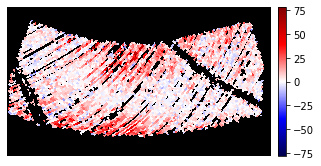

In [17]:
num = -1 # the 2D mapping before the fracture
dsiplay = np.nan_to_num(result_aspect_axis_change_rate_map, copy=False, nan=0.0, posinf=0.0, neginf=0.0)

lim_min = np.max(np.abs(dsiplay[:,:,num]))*-1
lim_max = np.max(np.abs(dsiplay[:,:,num]))

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.axis('off')
ax.invert_yaxis()

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

cm = plt.cm.seismic.copy()
cm.set_bad((0, 0, 0, 1))

mesh = ax.pcolormesh(np.ma.array(dsiplay[:,:,num], mask=nuclei_true[:,:,num]==0), cmap = cm)
mesh.set_clim(lim_min,lim_max)

fig.colorbar(mesh,cax=cax)

In [18]:
# np.savez_compressed('./data/map.npz',
#                     nuclei = nuclei_true[:,:,4:],
#                     area_change = result_area_change_rate_map,
#                     ecc_change = result_ecc_change_rate_map,
#                     aspect_axis_change = result_aspect_axis_change_rate_map,
#                     aspect_bbox_change = result_aspect_bbox_change_rate_map)